# SGAN 

> Semi-supervised learning is one of the most promising areas of practical application of GANs. Unlike supervised learning, in which we need a label for every example in our dataset, and unsupervised learning, in which no labels are used, semi-supervised learning has a class label for only a small subset of the training dataset. By internalizing hidden structures in the data, semi-supervised learning strives to generalize from the small subset of labeled data points to effectively classify new, previously unseen examples. Importantly, for semi-supervised learning to work, the labeled and unlabeled data must come from the same underlying distribution.

> The lack of labeled datasets is one of the main bottlenecks in machine learning research and practical applications. Although unlabeled data is abundant (the internet is a virtually limitless source of unlabeled images, videos, and text), assigning class labels to them is often prohibitively expensive, impractical, and time-consuming. It took two and a half years to hand-annotate the original 3.2 million images in the ImageNet—a database of labeled images that helped enable many of the advances in image processing and computer vision in the last decade.

> Semi-Supervised GAN (SGAN) is a Generative Adversarial Network whose Discriminator is a multiclass classifier. Instead of distinguishing between only two classes (real and fake), it learns to distinguish between N + 1 classes, where N is the number of classes in the training dataset, with one added for the fake examples produced by the Generator.

> For example, the MNIST dataset of handwritten digits has 10 labels (one label for each numeral, 0 to 9), so the SGAN Discriminator trained on this dataset would predict between 10 + 1 = 11 classes. In our implementation, the output of the SGAN Discriminator will be represented as a vector of 10 class probabilities (that sum up to 1.0) plus another probability that represents whether the image is real or fake.

> Turning the Discriminator from a binary to a multiclass classifier may seem like a trivial change, but its implications are more far-reaching than may appear at first glance. Let’s start with a diagram.the following shows the SGAN architecture.



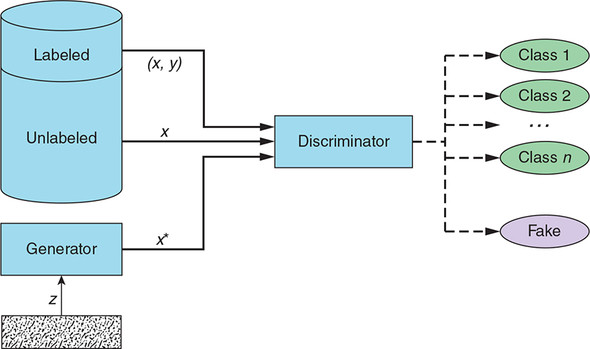

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [ ]:
'''The Dimensions of the traget images'''
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows , img_cols , channels)

z_dim = 100 #random noise input for generator 

num_classes = 10 #no. of classes to predict for semi supervised algo


In [ ]:
class Dataset:
    def __init__(self, num_labeled):

        self.num_labeled = num_labeled                                   

        (self.x_train, self.y_train), (self.x_test,                      
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5                   
            x = np.expand_dims(x, axis=3)                                
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        self.x_train = preprocess_imgs(self.x_train)                     
        self.y_train = preprocess_labels(self.y_train)

        self.x_test = preprocess_imgs(self.x_test)                       
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        idx = np.random.randint(0, self.num_labeled, batch_size)         
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], 
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [ ]:
num_labeled = 100

dataset = Dataset(num_labeled)

# Generator

In [ ]:
def build_generator(z_dim):

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))                           
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    model.add(BatchNormalization())                                          

    model.add(LeakyReLU(alpha=0.01))                                         

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')) 

    model.add(BatchNormalization())                                          

    model.add(LeakyReLU(alpha=0.01))                                         

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))  

    model.add(Activation('tanh'))                                            

    return model

# Discriminator

In [ ]:
def build_discriminator_net(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32,
                     kernel_size = 3,
                     strides=3,
                    input_shape=img_shape,
                    padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64,
                     kernel_size = 3,
                     strides=3,
                    input_shape=img_shape,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128,
                     kernel_size = 3,
                     strides=3,
                    input_shape=img_shape,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(num_classes))
    
    return model
    

In [ ]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Activation('softmax'))
    
    return model

In [ ]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    
    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

        return prediction
    model.add(Lambda(predict))
    
    return model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)                                                    
    model.add(discriminator)

    return model

                  

In [ ]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

In [ ]:
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [ ]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

      

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

      
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

In [ ]:
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [ ]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)      1
print("Test Accuracy: %.2f%%" % (100 * accuracy))